# Project of Parallel computing with Python
## DEUDIBE Gildas

1. In this section, we define a function rlogit that takes as input the sample size, the covariates matrix X (generated using the normal distribution) and the true parameter $\beta$ that includes some zeros coefficients. Using the this defined logistic distribution, we generate the vector of dependant variable Y that takes values in the set {0, 1}. In oder to systematically include the intercept, we assign a vector made by all ones to the first cloumn of the data X.


$$ P(Y=1|X=x)=\frac{e^{x^{T}\beta}}{1+e^{x^{T}\beta}} $$

Importing necessary modules

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import time
from concurrent.futures import ThreadPoolExecutor
from concurrent.futures import ProcessPoolExecutor

import dask
from time import sleep
from dask import delayed



### Definition of function generating of the data

In [ ]:
rng = np.random.RandomState(1234)      
def generate_X(n, beta):
    X = rng.randn(n*(len(beta)-1)).reshape(n, (len(beta)-1))  
    X = sm.add_constant(np.c_[X])                           # add one to the first column
    return X

def logit(x, beta):                     # Definition of Logit function that will help to generate the vector y
    l = x.dot(beta)
    return 1/(1+np.exp(-l))

def generate_Y(n, X, beta):
    p = logit(X, beta)                    # the logit fucntion is the one that generate our Y variable
    y = np.random.binomial(1., p)
    return y
    

def generate_wholedata(n, beta):
    X = generate_X(n, beta)
    y = generate_Y(n, X, beta).reshape(-1, 1)
    data = np.concatenate((X, y), axis=1)
    return data



#### Definition of sample size and the number of variables

In [254]:
rng = np.random.RandomState(1234)      
beta10, beta30, beta50 = rng.randn(10), rng.randn(30), rng.randn(50)
n = 1000

Function cv to parallelise

In [6]:
%%time
def cv(X, y):
    nobs = np.size(X,0)
    score = 0
    indices = np.arange(nobs)
    for i in range(nobs):
        sapp = indices != i
        sval = i
        model = sm.Logit(y[sapp], X[sapp,:]).fit(disp=False)
        ypred = np.round(model.predict(X[sval, :]))
        score += y[sval] == ypred
    return (score / nobs)

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 9.3 µs


### Plot the Strong-Scaling curves for different number of variables and n=1000

In this case, we will plot Number of processors in the x-axis vs run time in the y-axis. It is also possible to convert the runtime to a measure of efficiency instead


#### p=10 variables

In [256]:
%%time
data = generate_wholedata(n, beta10)
X = data[:, 0:-2]
y = data[:, -1]

def cv(X, y):
    nobs = np.size(X,0)
    score = 0
    indices = np.arange(nobs)
    for i in range(nobs):
        sapp = indices != i
        sval = i
        model = sm.Logit(y[sapp], X[sapp,:]).fit(disp=False)
        ypred = np.round(model.predict(X[sval, :]))
        score += y[sval] == ypred
    return (score / nobs)
cv(X, y)

CPU times: user 10.2 s, sys: 9.78 s, total: 20 s
Wall time: 2.21 s


array([0.731])

#### Using multi-threading

In [257]:
%%time
t10 =[]
for i in range(1, 16):
    st = time.time()
    with ThreadPoolExecutor(i) as executor:
        future = executor.submit(cv, X, y)
        print(future.result())
    et = time.time()
    ti = et-st
    t10.append(ti)  
    
print(X.shape)
print(y.shape)
print(t10)
#plt.plot(t10)       # Will plot this together with ProcessPoolExecutor in the same graph later.

[0.731]
[0.731]
[0.731]
[0.731]
[0.731]
[0.731]
[0.731]
[0.731]
[0.731]
[0.731]
[0.731]
[0.731]
[0.731]
[0.731]
[0.731]
(1000, 9)
(1000,)
[1.8397912979125977, 3.8453755378723145, 3.8480682373046875, 3.884437322616577, 4.137760877609253, 4.00499153137207, 4.085481643676758, 4.55876612663269, 4.650804281234741, 4.700561285018921, 4.643258094787598, 2.240849733352661, 2.1330904960632324, 2.1151938438415527, 2.1451327800750732]
CPU times: user 4min 3s, sys: 3min 51s, total: 7min 55s
Wall time: 52.8 s


#### Using multi-processing

In [261]:
%%time
p10 =[]
for i in range(1, 16):
    st = time.time()
    e = ProcessPoolExecutor(i)
    future = e.submit(cv, X, y)
    print(future.result())
    et = time.time()
    pi = et-st
    p10.append(pi)  
    
print(X.shape)
print(y.shape)
print(p10)


[0.731]
[0.731]
[0.731]
[0.731]
[0.731]
[0.731]
[0.731]
[0.731]
[0.731]
[0.731]
[0.731]
[0.731]
[0.731]
[0.731]
[0.731]
(1000, 9)
(1000,)
[3.9782307147979736, 2.13576602935791, 4.067142009735107, 2.2079522609710693, 4.25420880317688, 4.403581857681274, 4.37885308265686, 4.497697830200195, 2.7131614685058594, 4.6615753173828125, 4.8844075202941895, 4.908910512924194, 4.858966112136841, 4.845179557800293, 4.876030921936035]
CPU times: user 199 ms, sys: 886 ms, total: 1.09 s
Wall time: 1min 1s


#### Plotting the curve for both multi-threading and multi-processing in the same graph for comparison

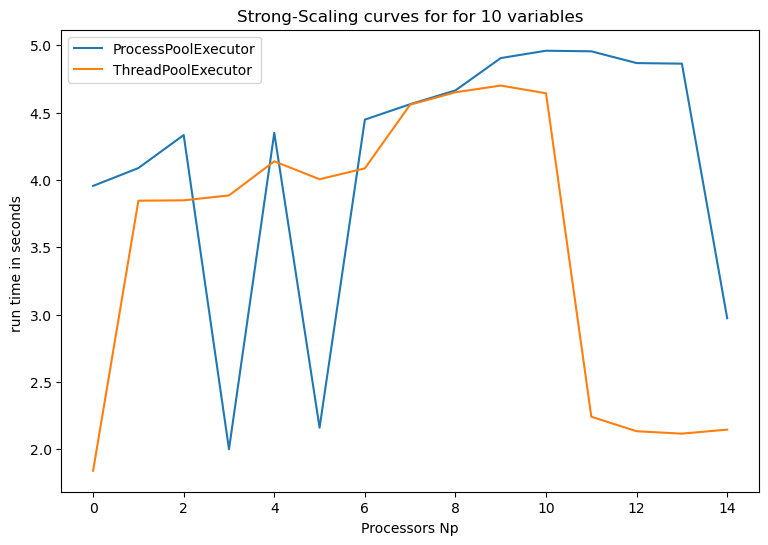

In [260]:
plt.plot(p10, label='ProcessPoolExecutor')
plt.plot(t10, label='ThreadPoolExecutor')

plt.title('Strong-Scaling curves for for 10 variables') 
plt.xlabel('Processors Np') 
plt.ylabel('run time in seconds ') 
plt.legend() 

For p = 10 variables, we observe that runtime of ProcessPoolExecutor start off high and decrease quickly later on. For higher number of processor, **Process** is slower. One reason might be that **Process** don't share its memory, communication between **processes** might take time, especially for large number of processors.

#### p = 30 variables

In [262]:
%%time
data = generate_wholedata(n, beta30)
X = data[:, 0:-2]
y = data[:, -1]

def cv(X, y):
    nobs = np.size(X,0)
    score = 0
    indices = np.arange(nobs)
    for i in range(nobs):
        sapp = indices != i
        sval = i
        model = sm.Logit(y[sapp], X[sapp,:]).fit(disp=False)
        ypred = np.round(model.predict(X[sval, :]))
        score += y[sval] == ypred
    return (score / nobs)
cv(X, y)

CPU times: user 43 s, sys: 38 s, total: 1min 20s
Wall time: 6.84 s


array([0.811])

In [263]:
%%time
t30 =[]
for i in range(1, 16):
    st = time.time()
    with ThreadPoolExecutor(i) as executor:
        future = executor.submit(cv, X, y)
        print(future.result())
    et = time.time()
    ti = et-st
    t30.append(ti)  
    
print(X.shape)
print(y.shape)
print(t30)
#plt.plot(t30)

[0.811]
[0.811]
[0.811]
[0.811]
[0.811]
[0.811]
[0.811]
[0.811]
[0.811]
[0.811]
[0.811]
[0.811]
[0.811]
[0.811]
[0.811]
(1000, 29)
(1000,)
[7.138538360595703, 6.852160453796387, 7.2271974086761475, 7.213772773742676, 7.433078050613403, 8.135867595672607, 7.8160560131073, 7.9283294677734375, 8.060654640197754, 8.051623344421387, 8.048094034194946, 8.043938398361206, 8.46023440361023, 8.182521343231201, 8.261500597000122]
CPU times: user 12min 4s, sys: 10min 56s, total: 23min 1s
Wall time: 1min 56s


In [265]:
%%time
p30 =[]
for i in range(1, 16):
    st = time.time()
    e = ProcessPoolExecutor(i)
    future = e.submit(cv, X, y)
    print(future.result())
    et = time.time()
    pi = et-st
    p30.append(pi)  
    
print(X.shape)
print(y.shape)
print(p30)

[0.811]
[0.811]
[0.811]
[0.811]
[0.811]
[0.811]
[0.811]
[0.811]
[0.811]
[0.811]
[0.811]
[0.811]
[0.811]
[0.811]
[0.811]
(1000, 29)
(1000,)
[7.187647342681885, 7.0873332023620605, 7.287673234939575, 8.376654863357544, 8.891016006469727, 9.3849036693573, 8.544250249862671, 8.503189325332642, 8.447673797607422, 9.127479076385498, 8.97592830657959, 8.780258655548096, 8.580510377883911, 8.484464645385742, 9.244940280914307]
CPU times: user 209 ms, sys: 984 ms, total: 1.19 s
Wall time: 2min 6s


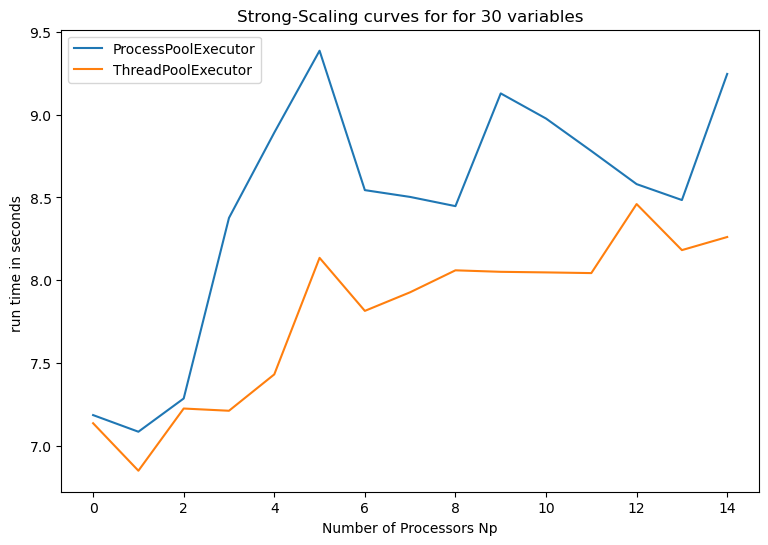

In [266]:
plt.plot(p30, label='ProcessPoolExecutor')
plt.plot(t30, label='ThreadPoolExecutor')

plt.title('Strong-Scaling curves for for 30 variables') 
plt.xlabel('Number of Processors Np') 
plt.ylabel('run time in seconds ') 
plt.legend() 

We observe that for p = 30 variables, thread is always effiient than process. let's see the last case where p = 50

#### p = 50

In [267]:
%%time
data = generate_wholedata(n, beta50)
X = data[:, 0:-2]
y = data[:, -1]

def cv(X, y):
    nobs = np.size(X,0)
    score = 0
    indices = np.arange(nobs)
    for i in range(nobs):
        sapp = indices != i
        sval = i
        model = sm.Logit(y[sapp], X[sapp,:]).fit(disp=False)
        ypred = np.round(model.predict(X[sval, :]))
        score += y[sval] == ypred
    return (score / nobs)
cv(X, y)

CPU times: user 1min 22s, sys: 59.3 s, total: 2min 21s
Wall time: 12.3 s


array([0.907])

In [268]:
%%time
t50 =[]
for i in range(1, 16):
    st = time.time()
    with ThreadPoolExecutor(i) as executor:
        future = executor.submit(cv, X, y)
        print(future.result())
    et = time.time()
    ti = et-st
    t50.append(ti)  
    
print(X.shape)
print(y.shape)
print(t50)
#plt.plot(t50)

[0.907]
[0.907]
[0.907]
[0.907]
[0.907]
[0.907]
[0.907]
[0.907]
[0.907]
[0.907]
[0.907]
[0.907]
[0.907]
[0.907]
[0.907]
(1000, 49)
(1000,)
[9.166807413101196, 9.33079481124878, 10.003790378570557, 10.819111824035645, 11.1406090259552, 11.980414152145386, 11.841613292694092, 11.78145980834961, 11.800818681716919, 12.213080644607544, 11.95975112915039, 11.74116587638855, 11.708886623382568, 11.793382406234741, 11.845258235931396]
CPU times: user 17min 58s, sys: 15min 26s, total: 33min 24s
Wall time: 2min 49s


In [269]:
%%time
p50 =[]
for i in range(1, 16):
    st = time.time()
    e = ProcessPoolExecutor(i)
    future = e.submit(cv, X, y)
    print(future.result())
    et = time.time()
    pi = et-st
    p50.append(pi)  
    
print(X.shape)
print(y.shape)
print(p50)

[0.907]
[0.907]
[0.907]
[0.907]
[0.907]
[0.907]
[0.907]
[0.907]
[0.907]
[0.907]
[0.907]
[0.907]
[0.907]
[0.907]
[0.907]
(1000, 49)
(1000,)
[11.499929428100586, 12.435270547866821, 13.257822036743164, 12.52335262298584, 12.35866117477417, 12.403584957122803, 12.543968439102173, 12.624552488327026, 13.102978706359863, 12.265999555587769, 12.716060400009155, 13.084533452987671, 12.641379833221436, 12.408349990844727, 12.394824504852295]
CPU times: user 258 ms, sys: 957 ms, total: 1.22 s
Wall time: 3min 8s


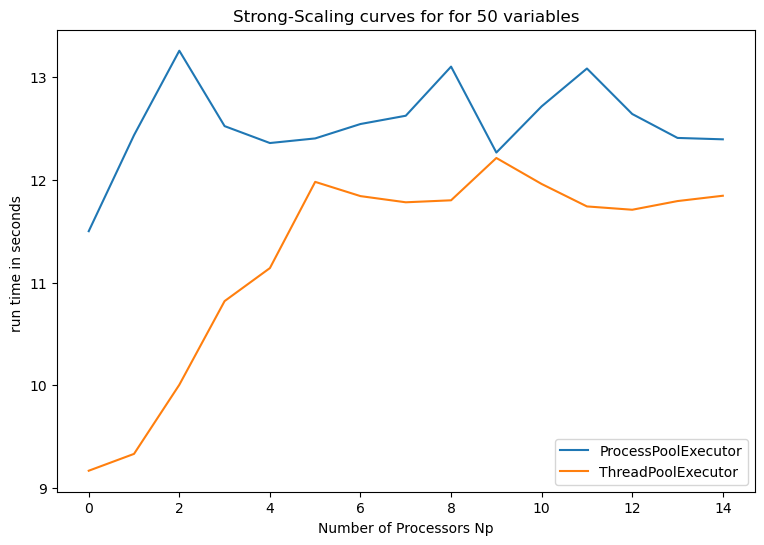

In [270]:

plt.plot(p50, label='ProcessPoolExecutor')
plt.plot(t50, label='ThreadPoolExecutor')

plt.title('Strong-Scaling curves for for 50 variables') 
plt.xlabel('Number of Processors Np') 
plt.ylabel('run time in seconds ') 
plt.legend() 

Ironically, the run time is larger for relying on multiples processor/cores than using fewer ones. This is probably due to the sample size which is not big enough (n=1000). For such a size, it is propably not worthing parallesing.


However, 


We observe the same conclusion of **Process** taking more time than **Thread** as for p = 10 or 30 variables (although for p = 10 variables, the separation is less prononced for very small nuber of processors/cores)


In conclusion, 
- Thread is faster because it share the same memory space
- parallel processing is slower because it slow data transfer




### Model selection

In this section we will implement and parallelize the strategy you use for the R project by testing variables
combination. The criteria for a variable to be relevant is if it increase the accuracy of the model, instead of relying on p-values.


- For this purpose, we set up a vector beta of coefficent (including the coefficient of the intercept)
- This suspposed to be the true coefficient that our procedure should be able to select
- This is why we make sure to include some zeros so that a strong enough procedure should not pick zeros coefficient as significant coefficient


In [28]:
n = 10000                                         # setting up number of observations
beta = [1, -2, 3, 0, 6, -1, 0, -0.5, 0, 0, 1.5]  # setting up the true beta that the procedure should provide (p=11)

#### Data generation using the true beta to reproduce

In [29]:
data = generate_wholedata(n, beta)
X = data[:, 0:-2]               # Select of variable except for the last one.
y = data[:, -1]                 # Select the last column which is the dependent variable
X1 = data[:, 1:-2]
print(X.shape)
print(y.shape)



(10000, 10)
(10000,)


##### Definition of function implementing the procedure of variable selection (forward selection)

In [ ]:
def forward_selection(X, y):                        # Define the forward selection procedure function
    initial_features = list(range(np.size(X, 1)))   # List of all covariates index
    best_features = []         #Start with an empty list and add features as soon as the a covariate became relevant
    score=0.5   # add a benchmark accurary score so that a relevant covariate will yield a greater than this value 
# accuracy score
# In such case I keep feature that yield an accuracy score of more than 0.8
    while (len(initial_features)>0):
        new_cv = np.full(np.size(X, 1), np.inf)     # Create a list of values of length equal to the number of variables (size of beta)
        remaining_features = list(set(initial_features)-set(best_features))
        for new_column in remaining_features:
            X̃ = X[:,best_features+[new_column]]
            new_cv[new_column] = cv(X̃, y).[0]   #cv provide us with array. We need to take the value inside the array
        best_cv= new_cv.max()
        if best_cv>score:
            best_features.append(np.argmax(best_cv))
        else:
            break
    return best_features


forward_selection(X1, y)

The procedure I operate is not very selecting the most relevant variable for the model. Not consistent with the beta I defined beforehand. This is why I tried to adapt the code provided by the professor. But instead of relying on p-value as selection critera, I decided that a variable is relevant if: c*** onsidering it in a selection provide a cross validation accuracy score greater than 0.7.*** we can define any other threshold for the accuracy score, 0.7 is just an arbitrary number but we suppose also that an accuracy score of 0.7 is good enough. 
NEvertheless, be mindfull that the cross validation procssus being a ***leave-one-out*** in a 10.000 sample size.The procedure is super slow. The procedure is provided below:

In [ ]:
def forward_regression(X, y):
    included = []
    nvars = np.size(X, 1)
    while True:
        changed=False
        excluded = list(set(range(nvars))-set(included))
        new_pval = np.full(nvars, np.inf)
        for new_column in excluded:
            X1 = X[:,included+[new_column]]
            model = cv(X1, y)
            new_pval[new_column] = model[-1]
        best_pval = new_pval.max()
        if best_pval > 0.7:
            best_feature = np.argmax(new_pval)
            included.append(best_feature)
            changed=True
        if not changed:
            return included

#forward_regression(X, y)    

# This function sometimes provide singular matrix. X are random so, we have 
# no control on the correlation of differents covariates. They should mosy likely be non correlated. but, 
#for the sake of experiment, we perform the selection using the covariates that do not include the intercept too.
#(the matrix X1)
forward_regression(X1, y)

##### Parallelise the model selection with concurent future 

Multi Threading Executor

In [ ]:
%%time
with ThreadPoolExecutor(8) as executor:                 # Choosing a number of processor equal 8
        future = executor.submit(forward_regression, X, y)
        print(future.result())

##### Parallelise the model selection with Dask

In [ ]:
%%time

model_selection = delayed(forward_regression)(X1, y)
model_selection.compute()